In [2]:
# Instala o pacote mahotas
!pip install mahotas gdown tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 36.3 MB/s eta 0:00:00


In [9]:
# Importa os pacotes necessários
import mahotas
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import gdown
from tqdm.auto import tqdm

# Tarefa

1. Divida o conjunto de dados 4scenes em 3 subconjuntos disjuntos: Treinamento (70%), Validação (15%) e Teste (15%).
f
2. Utilize o conjunto de validação para selecionar os melhores hiperparâmetros para os seguintes algoritmos de AM:

- [k-NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html): use o conjunto de validação para selecionar o melhor valor do hiperparâmetro k (número de vizinhos mais próximos).
- [Árvore de decisão](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html):use o conjunto de validação para selecionar o melhor valor do hiperparâmetro max_depth (profundidade da árvore).

Isto é, treine os modelos com o conjunto de treinamento e observe as suas performances no conjunto de validação para diferentes valores do hiperparâmetro em questão. Selecione a melhor configuração.

Plotar a accurácia (eixo y)  e hiperparâmetro (eixo x) considerando o conjunto de validação.

3. Treine os seguintes modelos com a união dos subconjuntos Treinamento + Validação. No caso do k-NN e da Árvore de Decisão utilize os hiperparâmetros selecionados no item anterior.
- [k-NN](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
- [Árvore de decisão](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

4. Compare a performance do k-NN e da Árvore de Decisão utilizando o conjunto de Teste e a função `classification_report` e também observando a matriz de confusão.

**Entregáveis**:

1. Código (notebook `*.ipynb`).

2. Relatório `*.pdf` (compile seus resultados e inclua as figuras).

In [4]:
# ===================================================================
# ETAPA 1: INSTALAÇÃO DE DEPENDÊNCIAS E DOWNLOAD DOS DADOS
# ===================================================================

!pip install gdown
!pip install mahotas

import gdown
import os

url = 'https://drive.google.com/uc?id=1bHHgeZ3H75oigySkcZG0S98unOJNft0b'
output = '4scenes.zip'

print("[INFO] Iniciando o download do dataset...")
gdown.download(url=url, output=output, quiet=False, fuzzy=True)

print("\n[INFO] Descompactando o dataset...")
!unzip -o -q 4scenes.zip

!rm 4scenes.zip
print("Dataset pronto!")

import mahotas
import cv2
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# EXTRAÇÃO DE CARACTERÍSTICAS

def describe(image):
    (means, stds) = cv2.meanStdDev(cv2.cvtColor(image, cv2.COLOR_BGR2HSV))
    colorStats = np.concatenate([means, stds]).flatten()

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    haralick = mahotas.features.haralick(gray).mean(axis=0)

    return np.hstack([colorStats, haralick])

# CARREGAMENTO DOS DADOS E EXTRAÇÃO DE FEATURES

imagesPath = './4scenes'

labels = []
data = []

files = os.listdir(imagesPath)

for image_name in tqdm(files, desc="[ETAPA 4] Extraindo features"):
    label = image_name.split("_")[0]
    image = cv2.imread(os.path.join(imagesPath, image_name))
    features = describe(image)
    labels.append(label)
    data.append(features)
data = np.array(data)
labels = np.array(labels)


[INFO] Iniciando o download do dataset...


Downloading...
From (original): https://drive.google.com/uc?id=1bHHgeZ3H75oigySkcZG0S98unOJNft0b
From (redirected): https://drive.google.com/uc?id=1bHHgeZ3H75oigySkcZG0S98unOJNft0b&confirm=t&uuid=c7268cc9-51cd-483e-b048-fe4c5adc4cfe
To: /content/4scenes.zip
100%|██████████| 54.8M/54.8M [00:00<00:00, 70.8MB/s]



[INFO] Descompactando o dataset...
Dataset pronto!


[ETAPA 4] Extraindo features:   0%|          | 0/1240 [00:00<?, ?it/s]

In [13]:
# DIVISÃO DO DATASET
print("\n[ETAPA 5] Dividindo o dataset...")

(trainData, tempData, trainLabels, tempLabels) = train_test_split(
    data, labels, test_size=0.30, random_state=42, stratify=labels
)

(valData, testData, valLabels, testLabels) = train_test_split(
    tempData, tempLabels, test_size=0.50, random_state=42, stratify=tempLabels
)

print(f"Treinamento: {len(trainData)} amostras")
print(f"Validação: {len(valData)} amostras")
print(f"Teste: {len(testData)} amostras")




[ETAPA 5] Dividindo o dataset...
Treinamento: 868 amostras
Validação: 186 amostras
Teste: 186 amostras


In [6]:
# HIPERPARÂMETROS (TUNING)
print("\n[ETAPA 6] Buscando melhores hiperparâmetros...")

k_values = range(1, 31)
knn_accuracies = []

for k in k_values:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(trainData, trainLabels)
    predictions = model.predict(valData)
    knn_accuracies.append(accuracy_score(valLabels, predictions))

best_k = k_values[np.argmax(knn_accuracies)]
print(f"Melhor 'k' para o k-NN: {best_k} (Acurácia de Validação: {max(knn_accuracies):.2%})")

depth_values = range(1, 31)
dt_accuracies = []

for depth in depth_values:
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    model.fit(trainData, trainLabels)
    predictions = model.predict(valData)
    dt_accuracies.append(accuracy_score(valLabels, predictions))

best_depth = depth_values[np.argmax(dt_accuracies)]
print(f"Melhor 'max_depth' para a Árvore de Decisão: {best_depth} (Acurácia de Validação: {max(dt_accuracies):.2%})")




[ETAPA 6] Buscando melhores hiperparâmetros...
Melhor 'k' para o k-NN: 3 (Acurácia de Validação: 67.20%)
Melhor 'max_depth' para a Árvore de Decisão: 6 (Acurácia de Validação: 81.72%)



[ETAPA 7] Gerando gráficos de acurácia...


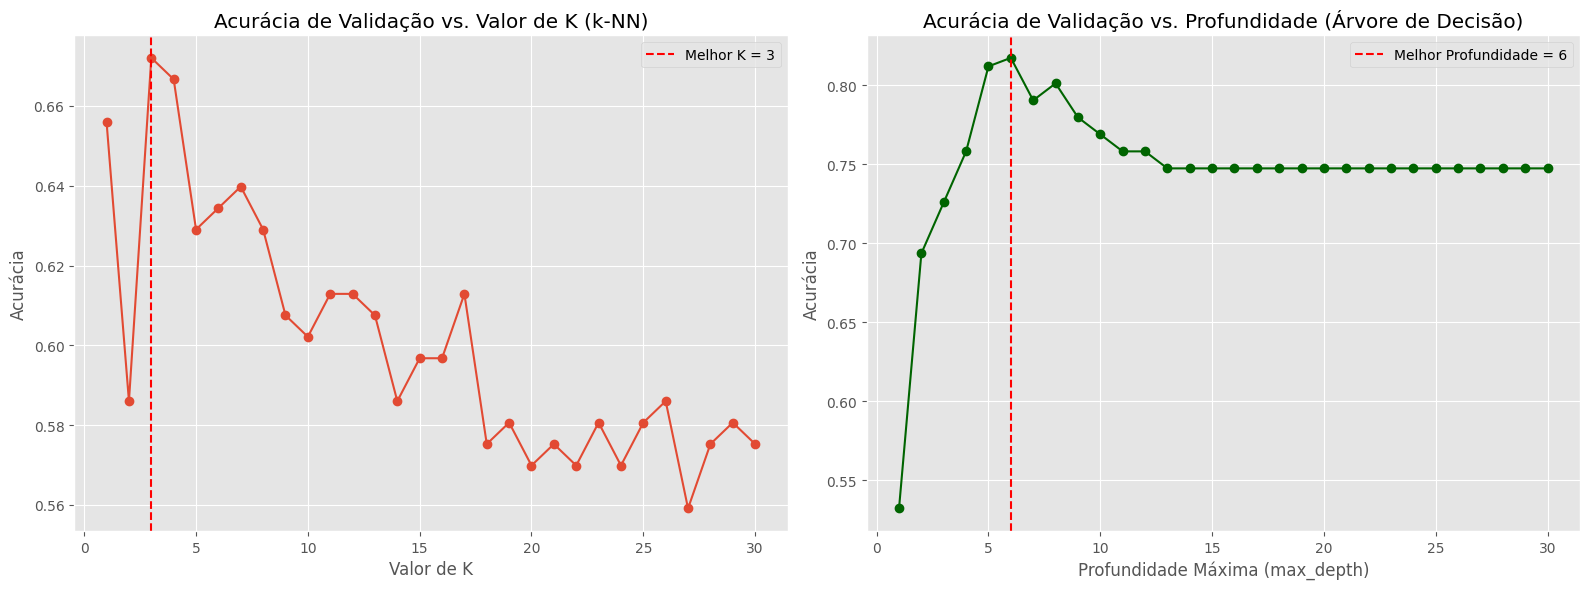

In [7]:

# VISUALIZAÇÃO DOS RESULTADOS DO TUNING
print("\n[ETAPA 7] Gerando gráficos de acurácia...")

plt.style.use('ggplot')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(k_values, knn_accuracies, marker='o')
ax1.set_title('Acurácia de Validação vs. Valor de K (k-NN)')
ax1.set_xlabel('Valor de K')
ax1.set_ylabel('Acurácia')
ax1.axvline(best_k, color='r', linestyle='--', label=f'Melhor K = {best_k}')
ax1.legend()

ax2.plot(depth_values, dt_accuracies, marker='o', color='darkgreen')
ax2.set_title('Acurácia de Validação vs. Profundidade (Árvore de Decisão)')
ax2.set_xlabel('Profundidade Máxima (max_depth)')
ax2.set_ylabel('Acurácia')
ax2.axvline(best_depth, color='r', linestyle='--', label=f'Melhor Profundidade = {best_depth}')
ax2.legend()

plt.tight_layout()
plt.show()


In [8]:
# REINAMENTO DOS MODELOS FINAIS
print("\n[ETAPA 8] Treinando modelos finais...")
finalTrainData = np.concatenate((trainData, valData))
finalTrainLabels = np.concatenate((trainLabels, valLabels))

knn_final_model = KNeighborsClassifier(n_neighbors=best_k)
knn_final_model.fit(finalTrainData, finalTrainLabels)
print("Modelo k-NN final treinado com sucesso!")

dt_final_model = DecisionTreeClassifier(max_depth=best_depth, random_state=42)
dt_final_model.fit(finalTrainData, finalTrainLabels)
print("Modelo de Árvore de Decisão final treinado com sucesso!")


[ETAPA 8] Treinando modelos finais...
Modelo k-NN final treinado com sucesso!
Modelo de Árvore de Decisão final treinado com sucesso!



[ETAPA 9] Avaliando performance no conjunto de TESTE...

--- RELATÓRIO DE CLASSIFICAÇÃO - K-NN ---
              precision    recall  f1-score   support

       coast       0.47      0.59      0.52        54
      forest       0.80      0.73      0.77        49
     highway       0.51      0.54      0.53        39
      street       0.72      0.52      0.61        44

    accuracy                           0.60       186
   macro avg       0.63      0.60      0.61       186
weighted avg       0.62      0.60      0.61       186


--- RELATÓRIO DE CLASSIFICAÇÃO - ÁRVORE DE DECISÃO ---
              precision    recall  f1-score   support

       coast       0.74      0.72      0.73        54
      forest       0.90      0.88      0.89        49
     highway       0.67      0.72      0.69        39
      street       0.81      0.80      0.80        44

    accuracy                           0.78       186
   macro avg       0.78      0.78      0.78       186
weighted avg       0.78      

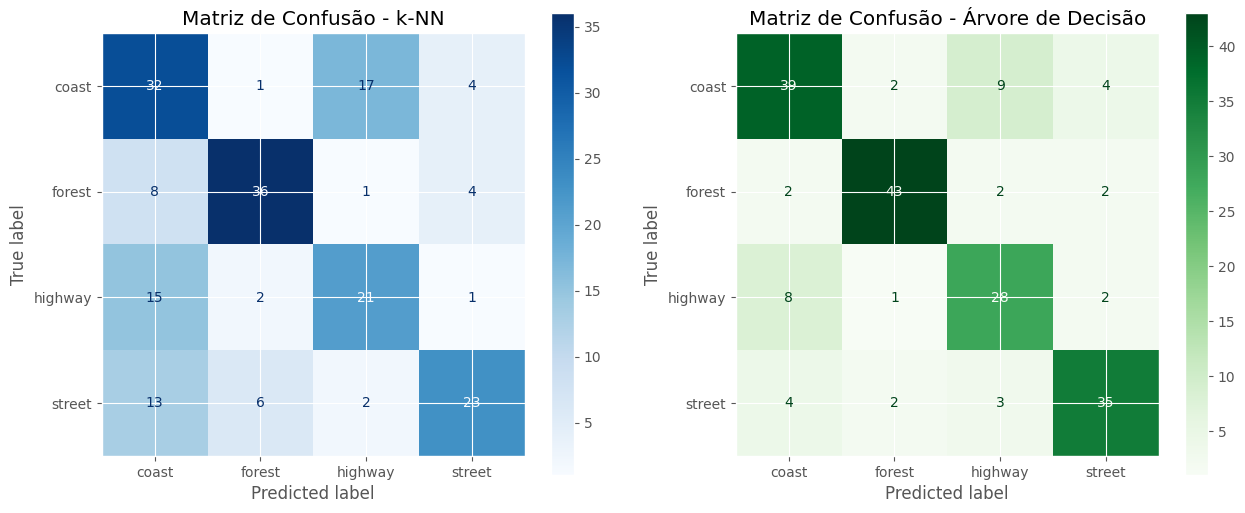

In [9]:
# AVALIAÇÃO E COMPARAÇÃO FINAL
print("\n[ETAPA 9] Avaliando performance no conjunto de TESTE...")

knn_predictions = knn_final_model.predict(testData)

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO - K-NN ---")
print(classification_report(testLabels, knn_predictions))

dt_predictions = dt_final_model.predict(testData)

print("\n--- RELATÓRIO DE CLASSIFICAÇÃO - ÁRVORE DE DECISÃO ---")
print(classification_report(testLabels, dt_predictions))


print("\nGerando Matrizes de Confusão...")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ConfusionMatrixDisplay.from_estimator(knn_final_model, testData, testLabels, ax=ax1, cmap=plt.cm.Blues)
ax1.set_title('Matriz de Confusão - k-NN')

ConfusionMatrixDisplay.from_estimator(dt_final_model, testData, testLabels, ax=ax2, cmap=plt.cm.Greens)
ax2.set_title('Matriz de Confusão - Árvore de Decisão')

plt.show()